In [10]:
import matplotlib.pyplot as plt
import numpy
import numpy.random
import numpy.linalg
import matplotlib
import matplotlib.pyplot as plt
import timeit
from math import sqrt
import sys

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [11]:
class CallType(object):
    def __init__(self, name, M, N, L, Eps):
        self.name = name
        self.M = M # refinement cost factor
        self.N = N # samples for convergence tests
        self.L = L # levels for convergence tests
        self.Eps = Eps

calltypes = [CallType("European", 4, 20000, 5, [0.005, 0.01, 0.02, 0.05, 0.1])]

def opre_gbm(l, N, calltype, randn=numpy.random.randn):
    M = calltype.M # refinement factor

    T   = 1.0  # interval
    r   = 0.05
    sig = 0.2
    K   = 100.0

    nf = M**l
    hf = T/nf

    nc = max(nf/M, 1)
    hc = T/nc

    sums = numpy.zeros(6)

    for N1 in range(1, N+1, 10000):
        N2 = min(10000, N - N1 + 1)

        X0 = K
        Xf = X0 * numpy.ones(N2)
        Xc = X0 * numpy.ones(N2)

        Af = 0.5 * hf * Xf
        Ac = 0.5 * hc * Xc

        Mf = numpy.array(Xf)
        Mc = numpy.array(Xc)

        if l == 0:
            dWf = sqrt(hf) * randn(1, N2)
            Xf[:] = Xf + r*Xf*hf + sig*Xf*dWf
            Af[:] = Af + 0.5*hf*Xf
            Mf[:] = numpy.minimum(Mf, Xf)
        else:
            for n in range(int(nc)):
                dWc = numpy.zeros((1, N2))

                for m in range(M):
                    dWf = sqrt(hf) * randn(1, N2)
                    dWc[:] = dWc + dWf
                    Xf[:] = (1.0 + r*hf)*Xf + sig*Xf*dWf
                    Af[:] = Af + hf*Xf
                    Mf[:] = numpy.minimum(Mf, Xf)

                Xc[:] = Xc + r*Xc*hc + sig*Xc*dWc
                Ac[:] = Ac + hc*Xc
                Mc[:] = numpy.minimum(Mc, Xc)

            Af[:] = Af - 0.5*hf*Xf
            Ac[:] = Ac - 0.5*hc*Xc

        if calltype.name == "European":
            Pf = numpy.maximum(0, Xf - K)
            Pc = numpy.maximum(0, Xc - K)
        elif calltype.name == "Asian":
            Pf = numpy.maximum(0, Af - K)
            Pc = numpy.maximum(0, Ac - K)
        elif calltype.name == "Lookback":
            beta = 0.5826 # special factor for offset correction
            Pf = Xf - Mf*(1 - beta*sig*sqrt(hf))
            Pc = Xc - Mc*(1 - beta*sig*sqrt(hc))
        elif calltype.name == "Digital":
            Pf = K * 0.5 * (numpy.sign(Xf - K) + 1)
            Pc = K * 0.5 * (numpy.sign(Xc - K) + 1)

        Pf = numpy.exp(-r*T)*Pf
        Pc = numpy.exp(-r*T)*Pc

        if l == 0:
            Pc = 0

        sums += numpy.array([numpy.sum(Pf - Pc),
                             numpy.sum((Pf - Pc)**2),
                             numpy.sum((Pf - Pc)**3),
                             numpy.sum((Pf - Pc)**4),
                             numpy.sum(Pf),
                             numpy.sum(Pf**2)])
    return numpy.array(sums)

In [12]:

class WeakConvergenceFailure(Exception):
    pass

def mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha_0, beta_0, gamma):

    if Lmin < 2:
        raise ValueError("Need Lmin >= 2")
    if Lmax < Lmin:
        raise ValueError("Need Lmax >= Lmin")
    if N0 <= 0 or eps <= 0 or gamma <= 0:
        raise ValueError("Need N0 > 0, eps > 0, gamma > 0")

    alpha = max(0, alpha_0)
    beta  = max(0, beta_0)
    theta = 0.25
    L = Lmin
    Nl   = numpy.zeros(L+1)
    suml = numpy.zeros((2, L+1))
    dNl  = N0*numpy.ones(L+1)

    while sum(dNl) > 0:
        for l in range(0, L+1):
            if dNl[l] > 0:
                sums       = mlmc_fn(l, int(dNl[l]))
                Nl[l]      = Nl[l] + dNl[l]
                suml[0, l] = suml[0, l] + sums[0]
                suml[1, l] = suml[1, l] + sums[1]

        ml = numpy.abs(       suml[0, :]/Nl)
        Vl = numpy.maximum(0, suml[1, :]/Nl - ml**2)

        for l in range(3, L+2):
            ml[l-1] = max(ml[l-1], 0.5*ml[l-2]/2**alpha)
            Vl[l-1] = max(Vl[l-1], 0.5*Vl[l-2]/2**beta)

        if alpha_0 <= 0:
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.solve(A, numpy.log2(ml[1:]))
            alpha = max(0.5, -x[0])

        if beta_0 <= 0:
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.solve(A, numpy.log2(Vl[1:]))
            beta = max(0.5, -x[0])

        Cl = 2**(gamma*numpy.arange(0, L+1))
        Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
        dNl = numpy.maximum(0, Ns-Nl)

        if sum(dNl > 0.01*Nl) == 0:
            rem = ml[L] / (2.0**alpha - 1.0)
            if rem > numpy.sqrt(theta)*eps:
                if L == Lmax:
                    raise WeakConvergenceFailure("Failed to achieve weak convergence")
                else:
                    L = L + 1
                    Vl = numpy.append(Vl, Vl[-1] / 2.0**beta)
                    Nl = numpy.append(Nl, 0.0)
                    suml = numpy.column_stack([suml, [0, 0]])

                    Cl = 2**(gamma*numpy.arange(0, L+1))
                    Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
                    dNl = numpy.maximum(0, Ns-Nl)

    P = sum(suml[0,:]/Nl)
    return (P, Nl)



In [13]:
def mlmc_plot(filename, nvert):
    file = open(filename, "r")
    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    l    = []
    epss = []
    mlmc_cost = []
    std_cost = []
    Ns = []

    for line in file:
        if line[0] == ' ' and '0' <= line[1] <= '9':
            splitline = [float(x) for x in line.split()]
            l.append(splitline[0])
            del1.append(splitline[1])
            del2.append(splitline[2])
            var1.append(splitline[3])
            var2.append(splitline[4])
            kur1.append(splitline[5])
            chk1.append(splitline[6])

        if '0' <= line[0] <= '9':
            splitline = [float(x) for x in line.split()]
            epss.append(splitline[0])
            mlmc_cost.append(splitline[1])
            std_cost.append(splitline[2])
            Ns.append(splitline[4:])

    plt.figure(figsize=(8, 6))

    plt.subplot(nvert, 2, 1)
    plt.plot(l,     numpy.log2(var2),     '*-',  label=r'$P_l$')
    plt.plot(l[1:], numpy.log2(var1[1:]), '*--', label=r'$P_l - P_{l-1}$')
    plt.xlabel('level $l$')
    plt.ylabel(r'$\mathrm{log}_2(\mathrm{variance})$')
    plt.legend(loc='lower left', fontsize='x-small')

    plt.subplot(nvert, 2, 2)
    plt.plot(l,     numpy.log2(numpy.abs(del2)),     '*-',  label=r'$P_l$')
    plt.plot(l[1:], numpy.log2(numpy.abs(del1[1:])), '*--', label=r'$P_l - P_{l-1}$')
    plt.xlabel('level $l$')
    plt.ylabel(r'$\mathrm{log}_2(|\mathrm{mean}|)$')
    plt.legend(loc='lower left', fontsize='x-small')

    if nvert == 3:
        plt.subplot(nvert, 2, 3)
        plt.plot(l[1:], chk1[1:], '*--')
        plt.xlabel('level $l$')
        plt.ylabel(r'consistency check')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

        plt.subplot(nvert, 2, 4)
        plt.plot(l[1:], kur1[1:], '*--')
        plt.xlabel('level $l$')
        plt.ylabel(r'kurtosis')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

    styles = ['o--', 'x--', 'd--', '*--', 's--']
    plt.subplot(nvert, 2, 2*nvert-1)
    for (eps, N, style) in zip(epss, Ns, styles):
        plt.semilogy(N, style, label=eps)
    plt.xlabel('level $l$')
    plt.ylabel('$N_l$')
    plt.legend(loc='upper right', frameon=True, fontsize='x-small')

    eps = numpy.array(epss)
    std_cost = numpy.array(std_cost)
    mlmc_cost = numpy.array(mlmc_cost)
    plt.subplot(nvert, 2, 2*nvert)
    plt.loglog(eps, eps**2 * std_cost,  '*-',  label='std MC')
    plt.loglog(eps, eps**2 * mlmc_cost, '*--', label='MLMC')
    plt.xlabel(r'accuracy $\epsilon$')
    plt.ylabel(r'$\epsilon^2$ cost')
    plt.legend(fontsize='x-small')
    axis = plt.axis(); plt.axis([min(eps), max(eps), axis[2], axis[3]])

    plt.subplots_adjust(wspace=0.3)

if __name__ == "__main__":
    import sys

    mlmc_plot(sys.argv[1], nvert=3)
    plt.savefig(sys.argv[1].replace(".txt", ".eps"))

FileNotFoundError: [Errno 2] No such file or directory: '-f'

In [14]:
def mlmc_test(mlmc_fn, M, N, L, N0, Eps, Lmin, Lmax, logfile):
    """
    Multilevel Monte Carlo test routine.

    mlmc_fn: the user low-level routine. Its interface is
      sums = mlmc_fn(l, N)
    with inputs
      l = level
      N = number of paths
    and a numpy array of outputs
      sums[0] = sum(Pf-Pc)
      sums[1] = sum((Pf-Pc)**2)
      sums[2] = sum((Pf-Pc)**3)
      sums[3] = sum((Pf-Pc)**4)
      sums[4] = sum(Pf)
      sums[5] = sum(Pf**2)

    M: refinement cost factor (2**gamma in general MLMC theorem)

    N: number of samples for convergence tests
    L: number of levels for convergence tests

    N0: initial number of samples for MLMC calculations
    Eps: desired accuracy array for MLMC calculations
    """

    # First, convergence tests

    write(logfile, "\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "*** Convergence tests, kurtosis, telescoping sum check ***\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "\n l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)    var(Pf)")
    write(logfile, "    kurtosis     check \n-------------------------")
    write(logfile, "--------------------------------------------------\n")

    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    cost = []

    for l in range(0, L+1):
        tic = timeit.default_timer()
        sums = mlmc_fn(l, N)
        toc = timeit.default_timer()
        cost.append(toc - tic)
        sums = sums/N

        if l == 0:
            kurt = 0.0
        else:
            kurt = (     sums[3]
                     - 4*sums[2]*sums[0]
                     + 6*sums[1]*sums[0]**2
                     - 3*sums[0]*sums[0]**3 ) / (sums[1]-sums[0]**2)**2

        del1.append(sums[0])
        del2.append(sums[4])
        var1.append(sums[1]-sums[0]**2)
        var2.append(max(sums[5]-sums[4]**2, 1.0e-10)) # fix for cases with var = 0
        kur1.append(kurt)

        if l == 0:
            check = 0
        else:
            check =          abs(       del1[l]  +      del2[l-1]  -      del2[l])
            check = check / ( 3.0*(sqrt(var1[l]) + sqrt(var2[l-1]) + sqrt(var2[l]) )/sqrt(N))
        chk1.append(check)

        write(logfile, "%2d   %8.4e  %8.4e  %8.4e  %8.4e  %8.4e  %8.4e \n" % \
                      (l, del1[l], del2[l], var1[l], var2[l], kur1[l], chk1[l]))

    if kur1[-1] > 100.0:
        write(logfile, "\n WARNING: kurtosis on finest level = %f \n" % kur1[-1]);
        write(logfile, " indicates MLMC correction dominated by a few rare paths; \n");
        write(logfile, " for information on the connection to variance of sample variances,\n");
        write(logfile, " see http://mathworld.wolfram.com/SampleVarianceDistribution.html\n\n");

    if max(chk1) > 1.0:
        write(logfile, "\n WARNING: maximum consistency error = %f \n" % max(chk1))
        write(logfile, " indicates identity E[Pf-Pc] = E[Pf] - E[Pc] not satisfied \n\n")

    L1 = int(numpy.ceil(0.4*L));
    L2 = L+1;
    pa    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(del1[L1:L2])), 1);  alpha = -pa[0];
    pb    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(var1[L1:L2])), 1);  beta  = -pb[0];
    gamma = numpy.log2(cost[-1]/cost[-2]);

    write(logfile, "\n******************************************************\n");
    write(logfile, "*** Linear regression estimates of MLMC parameters ***\n");
    write(logfile, "******************************************************\n");
    write(logfile, "\n alpha = %f  (exponent for MLMC weak convergence)\n" % alpha);
    write(logfile, " beta  = %f  (exponent for MLMC variance) \n" % beta);
    write(logfile, " gamma = %f  (exponent for MLMC cost) \n" % gamma);

    # Second, MLMC complexity tests

    write(logfile, "\n");
    write(logfile, "***************************** \n");
    write(logfile, "*** MLMC complexity tests *** \n");
    write(logfile, "***************************** \n\n");
    write(logfile, "  eps   mlmc_cost   std_cost  savings     N_l \n");
    write(logfile, "----------------------------------------------- \n");

    gamma = numpy.log2(M)
    theta = 0.25

    for eps in Eps:
        (P, Nl) = mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha, beta, gamma)
        l = len(Nl) - 1
        mlmc_cost = (1 + 1.0/M)*sum(Nl * M**numpy.arange(0, l+1))
        std_cost  = sum(var2[-1]*M**numpy.arange(0, l+1))/((1.0 -theta)*eps**2)

        write(logfile, "%.4f  %.3e  %.3e  %7.2f " % (eps, mlmc_cost, std_cost, std_cost/mlmc_cost))
        write(logfile, " ".join(["%9d" % n for n in Nl]))
        write(logfile, "\n")

    write(logfile, "\n")

def write(logfile, msg):
    """
    Write to both sys.stdout and to a logfile.
    """
    logfile.write(msg)
    sys.stdout.write(msg)




**********************************************************
*** Convergence tests, kurtosis, telescoping sum check ***
**********************************************************

 l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)    var(Pf)    kurtosis     check 
---------------------------------------------------------------------------
 0   9.9908e+00  9.9908e+00  1.5944e+02  1.5944e+02  0.0000e+00  0.0000e+00 
 1   2.2867e-01  1.0459e+01  4.4115e+00  2.0231e+02  1.9551e+01  3.8933e-01 
 2   2.6045e-02  1.0483e+01  1.0728e+00  2.1541e+02  1.2373e+01  2.2953e-03 
 3   8.4580e-03  1.0554e+01  2.7705e-01  2.1811e+02  7.4700e+00  9.7575e-02 
 4   1.7469e-04  1.0589e+01  6.9073e-02  2.2270e+02  6.4479e+00  5.4636e-02 
 5   -1.3800e-04  1.0477e+01  1.7219e-02  2.1651e+02  5.9241e+00  1.7637e-01 

******************************************************
*** Linear regression estimates of MLMC parameters ***
******************************************************

 alpha = 2.827789  (exponent for MLMC wea

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


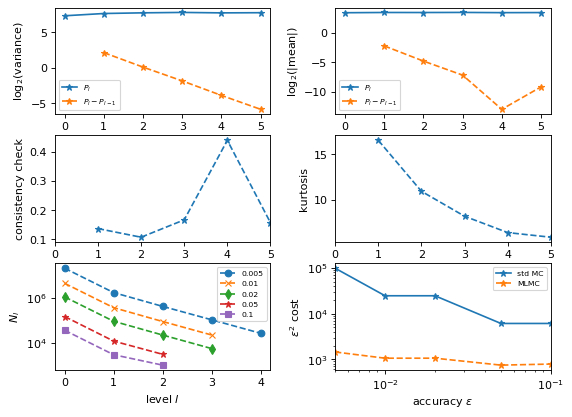

In [15]:
if __name__ == "__main__":
    N0 = 1000 # initial samples on coarse levels
    Lmin = 2  # minimum refinement level
    Lmax = 6  # maximum refinement level

    for (i, calltype) in enumerate(calltypes):
        def opre_l(l, N):
            return opre_gbm(l, N, calltype)

        filename = "opre_gbm%d.txt" % (i+1)
        logfile = open(filename, "w")
        mlmc_test(opre_l, calltype.M, calltype.N, calltype.L, N0, calltype.Eps, Lmin, Lmax, logfile)
        #del logfile
        mlmc_plot(filename, nvert=3)
        plt.savefig(filename.replace('.txt', '.eps'))